In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [23]:
vehiculo = 'DA03'

In [24]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
elif vehiculo == 'DA04':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_04'
contenido = os.listdir(path_log)
len(contenido)

113

In [25]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [26]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [27]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

15

In [28]:
contenido_filtrado

['2025-12-01 09-55-40.tlog',
 '2025-12-17 19-51-38.tlog',
 '2025-12-17 22-05-37.tlog',
 '2025-12-17 22-14-12.tlog',
 '2025-12-18 00-13-56.tlog',
 '2025-12-18 01-47-53.tlog',
 '2025-12-18 01-53-34.tlog',
 '2025-12-18 03-49-38.tlog',
 '2025-12-18 18-25-58.tlog',
 '2025-12-18 19-23-05.tlog',
 '2025-12-18 22-21-10.tlog',
 '2025-12-19 00-49-20.tlog',
 '2025-12-19 02-01-06.tlog',
 '2025-12-19 02-48-49.tlog',
 '2025-12-19 05-46-57.tlog']

In [29]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        print(name)
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [30]:
lineas, names = leer_logs(contenido_filtrado)
lineas

2025-12-01 09-55-40.tlog
2025-12-17 19-51-38.tlog
2025-12-17 22-05-37.tlog
2025-12-17 22-14-12.tlog
2025-12-18 00-13-56.tlog
2025-12-18 01-47-53.tlog
2025-12-18 01-53-34.tlog
2025-12-18 03-49-38.tlog
2025-12-18 18-25-58.tlog
2025-12-18 19-23-05.tlog
2025-12-18 22-21-10.tlog
2025-12-19 00-49-20.tlog
2025-12-19 02-01-06.tlog
2025-12-19 02-48-49.tlog
2025-12-19 05-46-57.tlog


[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-62.836 -17.178, -62.836 -17.178, -62.836 -17.178, -62.836 -17....>,
 <LINESTRING (-62.835 -17.19, -62.835 -17.19, -62.835 -17.19, -62.835 -17.19,...>,
 <LINESTRING (-63.069 -17.215, -63.069 -17.215, -63.069 -17.215, -63.069 -17....>,
 <LINESTRING (-63.112 -17.252, -63.112 -17.252, -63.112 -17.252, -63.112 -17....>,
 <LINESTRING (-63.069 -17.215, -63.069 -17.215, -63.069 -17.215, -63.069 -17....>,
 <LINESTRING (-63.167 -17.214, -63.167 -17.214, -63.167 -17.214, -63.167 -17....>,
 <LINESTRING (-63.311 -17.186, -63.311 -17.186, -63.311 -17.186, -63.311 -17....>,
 <LINESTRING (-63.311 -17.186, -63.311 -17.186, -63.311 -17.186, -63.311 -17....>,
 <LINESTRING (-63.276 -17.252, -63.276 -17.252, -63.276 -17.252, -63.276 -17....>,
 <LINESTRING (-63.263 -17.248, -63.263 -17.248, -63.263 -17.248, -63.263 -17....>,
 <LI

In [31]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-12-01 09-55-40.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2025-12-17 19-51-38.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
2,2025-12-17 22-05-37.tlog,"LINESTRING (-62.83563 -17.17770, -62.83563 -17..."


In [32]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [33]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [34]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [36]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-12-17 19-51-38.tlog,"LINESTRING (-62.83513 -17.18966, -62.83512 -17...",5496,DA03
1,2025-12-17 19-51-38.tlog,"LINESTRING (-62.83588 -17.18690, -62.83588 -17...",2488,DA03
2,2025-12-17 19-51-38.tlog,"LINESTRING (-62.83618 -17.18564, -62.83618 -17...",2989,DA03


<Axes: >

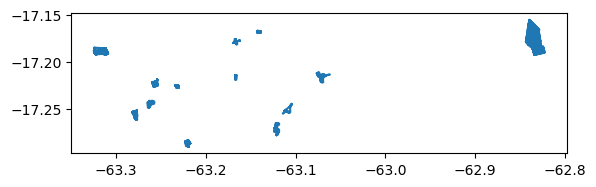

In [37]:
gdf_lines.plot()

In [43]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

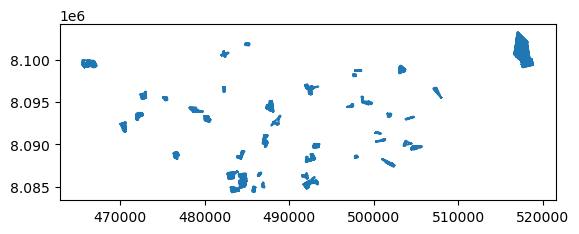

In [44]:
gdf_lines_utm.plot()

In [45]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [46]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-12-09 18-47-32.tlog,"LINESTRING (485956.508 8084921.126, 485956.497...",2147,DA03,0
1,2025-12-09 18-47-32.tlog,"LINESTRING (486849.601 8085062.329, 486849.612...",1701,DA03,0
2,2025-12-09 19-12-30.tlog,"LINESTRING (486304.068 8086328.902, 486304.068...",1506,DA03,0
3,2025-12-09 20-30-08.tlog,"LINESTRING (484013.518 8084530.850, 484013.518...",4740,DA03,0
4,2025-12-09 21-37-06.tlog,"LINESTRING (484184.815 8085262.837, 484184.804...",5046,DA03,0
...,...,...,...,...,...
74,2025-12-19 02-01-06.tlog,"LINESTRING (472080.220 8092989.507, 472080.220...",2320,DA03,0
75,2025-12-19 02-48-49.tlog,"LINESTRING (476915.775 8088705.329, 476915.775...",2781,DA03,0
76,2025-12-19 05-46-57.tlog,"LINESTRING (473018.659 8096186.524, 473017.967...",4145,DA03,0
77,2025-12-19 05-46-57.tlog,"LINESTRING (475118.302 8095545.346, 475118.313...",1885,DA03,0


In [47]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)